In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from tqdm.notebook import tqdm
from typing import List, Tuple, Union
import time

# Some Utility Functions

In [2]:
def read_json(fpath: str):
    with open(fpath, "r") as f:
        data = json.load(f)
        f.close()
    return data

root_output_path = "../data/output"
file_list = [fname for fname in os.listdir(root_output_path) if fname.endswith(".json")]
file_list

['data_princeton-nlp-Sheared-LLaMA-1-3B_n500_synthid.json',
 'data_google-gemma-3-270m_n200_gumbel.json',
 'data_facebook-opt-1-3b_n500_pf.json',
 'data_facebook-opt-125m_n500_inverse.json',
 'data_google-gemma-3-270m_n500_gumbel.json',
 'data_facebook-opt-1-3b_n500_unwatermarked.json',
 'data_mistralai-Mistral-7B-v0-1_n500_pf.json',
 'data_google-gemma-3-270m_n500_inverse.json',
 'data_meta-llama-Meta-Llama-3-8B_n500_gumbel.json',
 'data_facebook-opt-1-3b_n500_redgreen.json',
 'data_google-gemma-3-270m_n500_redgreen.json',
 'data_facebook-opt-1-3b_n500_synthid.json',
 'data_meta-llama-Meta-Llama-3-8B_n500_pf.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_pf.json',
 'data_facebook-opt-125m_n500_unwatermarked.json',
 'data_princeton-nlp-Sheared-LLaMA-1-3B_n500_gumbel.json',
 'data_google-gemma-3-270m_n501_gumbel.json',
 'data_mistralai-Mistral-7B-v0-1_n500_redgreen.json',
 'data_mistralai-Mistral-7B-v0-1_n500_gumbel.json',
 'data_facebook-opt-1-3b_n500_inverse.json',
 'data_mistral

In [3]:
# IOU is the typical metric that is tracked in these scenarios
def get_iou(intervalsA: List[Tuple[int, int]], intervalsB: List[Tuple[int, int]]):
  coordsA = set([x for start, end in intervalsA for x in range(start, end)])
  coordsB = set([x for start, end in intervalsB for x in range(start, end)])
  num = len(coordsA.intersection(coordsB))
  denom = len(coordsA.union(coordsB))
  return (num / denom)

def get_hit_counts(true_intervals: List[Tuple[int, int]], estimated_intervals: List[Tuple[int, int]]):
  # count how many of the true intervals we have nonzero IOU
  hit_count = 0
  est_intervals = estimated_intervals.copy()
  for true_int in true_intervals:
    max_iou = 0
    max_index = None
    for j in range(len(est_intervals)):
      iou = get_iou([true_int], [est_intervals[j]])
      if iou > 0 and iou > max_iou:
        max_iou = iou
        max_index = j
    
    if max_iou > 0 and max_index is not None:
      hit_count += 1
      est_intervals.pop(max_index)

  return hit_count

def get_rand_index(intervalsA: List[Tuple[int, int]], intervalsB: List[Tuple[int, int]], n: int):
  # convert interval endpoints to sorted changepoints for fast computation
  # reference: https://arxiv.org/pdf/2112.03738
  cpA = sorted([0, n] + [x for interval in intervalsA for x in interval])
  cpB = sorted([0, n] + [x for interval in intervalsB for x in interval])
  num = 0
  for i in range(len(cpA) - 1):
    for j in range(len(cpB) - 1):
      nij = max(0, min(cpA[i+1], cpB[j+1]) - max(cpA[i], cpB[j]))
      num += (nij * abs(cpA[i+1] - cpB[j+1]))
  return 1 - 2 * num / (n*(n-1))


# metric to find the symmetric differences
def get_symmetric_difference(intA, intB):
  sA, eA = intA
  sB, eB = intB
  return abs(sA - sB) + abs(eA - eB)

In [4]:
# get summary of detection methods applied for a specific data
def get_summarized_results(data, get_interval_func, add_plot = False, verbose = True):
    metrics_list = []
    interval_endpoints = []
    true_intervals =  [
        (start, end) for (start, end, interval_type) in data['configuration']['intervals'] if interval_type != 'unwatermarked'
    ]

    n = 0
    for sample_index, sample_data in tqdm(list(enumerate(data["data"]))):
        pivots = sample_data["pivots"]
        n = max(n, len(pivots))
        pivots = np.array(pivots)
        pivots[np.isinf(pivots)] = pivots[~np.isinf(pivots)].max() # replace by maximum for infinite values
        est_intervals, time_taken = get_interval_func(pivots)
        
        # add detected endpoints to array
        for left_end, right_end in est_intervals:
            interval_endpoints.append(left_end)
            interval_endpoints.append(right_end)

        # calculate metrics
        hit_count = get_hit_counts(true_intervals, est_intervals)
        metric_row = {
            "sample_index": sample_index,
            "detected_intervals_count": len(est_intervals),
            "iou": get_iou(est_intervals, true_intervals),
            "recall": hit_count / max(len(true_intervals), 1),  # Recall
            "precision": hit_count / max(len(est_intervals), 1),  # Precision
            "rand_index": get_rand_index(true_intervals, est_intervals, n),
            "time": time_taken
        }
        metrics_list.append(metric_row)

    metric_df = pd.DataFrame(metrics_list)
    # metric_df['f1'] = 2 * metric_df['precision'] * metric_df['recall'] / (metric_df['precision'] + metric_df['recall'])
    f1 = 2 * metric_df['precision'].mean() * metric_df['recall'].mean() / (metric_df['precision'].mean() + metric_df['recall'].mean())

    return {
        "model_name": data['configuration']['model_name'],
        "iou": metric_df['iou'].mean(),
        "precision": metric_df['precision'].mean(),
        "recall": metric_df['recall'].mean(),
        "f1": f1,
        "rand_index": metric_df['rand_index'].mean()
    }

    # if verbose:
    #     # print the description of the setup
    #     print(f"Model name: {data['configuration']['model_name']}")
    #     print(f"Output tokens: {data['configuration']['out_tokens']}")
    #     print(f"Vocab size: {data['configuration']['vocab_size']}")
    #     print(f"Segment types: {', '.join([interval_type for start, end, interval_type in data['configuration']['intervals']])}\n")

    #     # Summary 1: Frequency table of # of detected intervals
    #     frequency_table = metric_df['detected_intervals_count'].value_counts().reset_index()
    #     frequency_table.columns = ['value', 'frequency']
    #     frequency_table['proportion'] = frequency_table['frequency'] / frequency_table['frequency'].sum()
    #     print(f"Frequency Table of Detected Intervals: \n{frequency_table.sort_values(by = "frequency", ascending=False).head(5)}")

    #     # Summary 2: Describe the scores
    #     print(f"\nAdditional Metrics: \nMean IOU: {metric_df['iou'].mean()}\nMean Time Taken: {metric_df['time'].mean()}")

    # # draw a histogram of detected intervals endpoints
    # if add_plot:
    #     plt.figure(figsize=(10, 6))
    #     h = sns.histplot(
    #         data=pd.DataFrame({'endpoints': interval_endpoints}),
    #         x='endpoints',
    #         binwidth=n/100
    #     )
    #     plt.vlines(
    #         x=[int(a) for x in true_intervals for a in x],
    #         ymin=h.get_ylim()[0],
    #         ymax = h.get_ylim()[1],
    #         colors="red"
    #     )
    #     plt.title('Histogram of Detected Endpoints')
    #     plt.xlim(0, n)
    #     plt.grid(True)
    #     plt.tight_layout()
    #     plt.show()

    # return {
    #     "model_name": data['configuration']['model_name'],
    #     "iou": metric_df['iou'].mean(),
    #     "time": metric_df['time'].mean() * 1000
    # }

# Calculate Metrics

In [5]:
from detections import EpidemicDetectorV3, AligatorCPPDetector, WinMaxDetector, FixedWindowDetector, WaterSeekerDetector, SeedBSNotDetector
from watermarking_func import null_distn_gumbel, null_distn_inverse, null_distn_redgreen, null_distn_synthid, null_distn_pf

In [6]:
# best block sizes for epidemic
# block_size = 65, c = 1

null_dist_list = {
    "gumbel": null_distn_gumbel,
    "inverse": null_distn_inverse,
    "redgreen": null_distn_redgreen,
    "pf": null_distn_pf
}

model_list = [
    "data_facebook-opt-125m_n500",
    "data_google-gemma-3-270m_n500",
    "data_facebook-opt-1-3b_n500",
    "data_princeton-nlp-Sheared-LLaMA-1-3B_n500",
    "data_mistralai-Mistral-7B-v0-1_n500",
    "data_meta-llama-Meta-Llama-3-8B_n500"
]
watermark_method = "gumbel"
null_distn = null_dist_list[watermark_method]


In [7]:
outputs = []
for fmodel in model_list:
    fname = f"{fmodel}_{watermark_method}.json"
    data = read_json(os.path.join(root_output_path, fname))
    vocab_size = data['configuration']['vocab_size']
    model_name = data['configuration']['model_name']
    print(f"\n\nLoaded file {fname} with model {model_name} and vocab size {vocab_size}\n")

    # Run epidemic
    def get_epidemic_intervals(x):
        d = EpidemicDetectorV3(vocab_size)
        return d.detect(x, null_distn=null_distn, block_size=65, c = 1) 
    
    res = get_summarized_results(data, get_epidemic_intervals, verbose=False)
    res['method'] = "Epidemic"
    res['model_name'] = model_name
    res['vocab_size'] = vocab_size
    outputs.append(res)


    # Run aligator
    def get_aligator_intervals(x):
        d = AligatorCPPDetector(vocab_size)
        return d.detect(np.array(x), null_distn)
        
    res = get_summarized_results(data, get_aligator_intervals, verbose=False)
    res['method'] = "Aligator"
    res['model_name'] = model_name
    res['vocab_size'] = vocab_size
    outputs.append(res)

    # Run seedbs
    def get_seedbs_intervals(x):
        d = SeedBSNotDetector(vocab_size)
        return d.detect(x, null_distn)
    res = get_summarized_results(data, get_seedbs_intervals, verbose=False)
    res['method'] = "SeedBS_NOT"
    res['model_name'] = model_name
    res['vocab_size'] = vocab_size
    outputs.append(res)

    # Run fixed width
    def get_fixedwidth_intervals(x):
        d = FixedWindowDetector(vocab_size)
        return d.detect(x, null_distn)
    res = get_summarized_results(data, get_fixedwidth_intervals, verbose=False)
    res['method'] = "FW"
    res['model_name'] = model_name
    res['vocab_size'] = vocab_size
    outputs.append(res)
    
    # Run waterseeker
    def get_seek_intervals(x):
        d = WaterSeekerDetector(vocab_size)
        return d.detect(x, null_distn)
    res = get_summarized_results(data, get_seek_intervals, verbose=False)
    res['method'] = "Waterseeker"
    res['model_name'] = model_name
    res['vocab_size'] = vocab_size
    outputs.append(res)


output_df = pd.DataFrame(outputs)

# output_df = output_df[['model_name', 'vocab_size', 'method', 'iou', 'precision', 'recall', 'f1']].round(3)
# output_df



Loaded file data_facebook-opt-125m_n500_gumbel.json with model facebook/opt-125m and vocab size 50272



  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

TypeError: return arrays must be of ArrayType

In [17]:
output_df = output_df[['model_name', 'vocab_size', 'method', 'iou', 'precision', 'recall', 'f1', 'rand_index']].round(3)

# output_df
print(output_df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lrlrrrrr}
\toprule
model_name & vocab_size & method & iou & precision & recall & f1 & rand_index \\
\midrule
facebook/opt-125m & 50272 & Epidemic & 0.925 & 0.998 & 0.998 & 0.998 & 0.980 \\
facebook/opt-125m & 50272 & Aligator & 0.665 & 0.345 & 0.978 & 0.510 & 0.935 \\
facebook/opt-125m & 50272 & FW & 0.469 & 0.009 & 1.000 & 0.018 & 0.805 \\
facebook/opt-125m & 50272 & Waterseeker & 0.712 & 1.000 & 0.905 & 0.950 & 0.891 \\
google/gemma-3-270m & 262144 & Epidemic & 0.935 & 1.000 & 1.000 & 1.000 & 0.982 \\
google/gemma-3-270m & 262144 & Aligator & 0.558 & 0.252 & 0.952 & 0.399 & 0.906 \\
google/gemma-3-270m & 262144 & FW & 0.507 & 0.008 & 1.000 & 0.016 & 0.833 \\
google/gemma-3-270m & 262144 & Waterseeker & 0.614 & 1.000 & 0.782 & 0.878 & 0.841 \\
facebook/opt-1.3b & 50272 & Epidemic & 0.904 & 1.000 & 0.990 & 0.995 & 0.972 \\
facebook/opt-1.3b & 50272 & Aligator & 0.446 & 0.216 & 0.928 & 0.350 & 0.887 \\
facebook/opt-1.3b & 50272 & FW & 0.517 & 0.008 & 0.992 & 0.017 & 0.83

# Watermark Detection Speed Comparison

In [18]:
from detections import AligatorCPPDetector, FixedWindowDetector, WaterSeekerDetector, EpidemicDetectorV2
from watermarking_func import null_distn_gumbel, null_distn_inverse, null_distn_redgreen, null_distn_pf

In [19]:
from itertools import product
from tqdm.notebook import tqdm

B = 100  # number of replications
vocab_size = 10000
nlist = [100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 5000, 7500, 10000]

rows = []
for n, b in tqdm(list(product(nlist, range(B)))):
    pivots = np.random.standard_exponential(size = n)  # (n, )  # generate sample gumbel pivots
    random_index = int(np.random.rand() * n/2)
    pivots[random_index:(random_index + int(n/6))] += 5  # create some simulated wm segments

    # run aligator
    d = AligatorCPPDetector(vocab_size)
    _, t = d.detect(pivots, null_distn_gumbel)
    rows.append({ "index": b, "n": n, "method": "Aligator", "time": t })

    # run fw
    d = FixedWindowDetector(vocab_size)
    _, t = d.detect(pivots, null_distn_gumbel)
    rows.append({ "index": b, "n": n, "method": "FW", "time": t })

    # run waterseeker
    d = WaterSeekerDetector(vocab_size)
    _, t = d.detect(pivots, null_distn_gumbel)
    rows.append({ "index": b, "n": n, "method": "Waterseeker", "time": t })

    # run epidemic
    d = EpidemicDetectorV2(vocab_size)
    _, t = d.detect(pivots, null_distn_gumbel)
    rows.append({ "index": b, "n": n, "method": "Epidemic", "time": t })


timedf = pd.DataFrame(rows)
timedf.head()


  0%|          | 0/1200 [00:00<?, ?it/s]

,index,n,method,time
0,0,100,Aligator,0.003659
1,0,100,FW,0.000077
2,0,100,Waterseeker,0.000155
3,0,100,Epidemic,0.000082
4,1,100,Aligator,0.003758


(4800, 4)


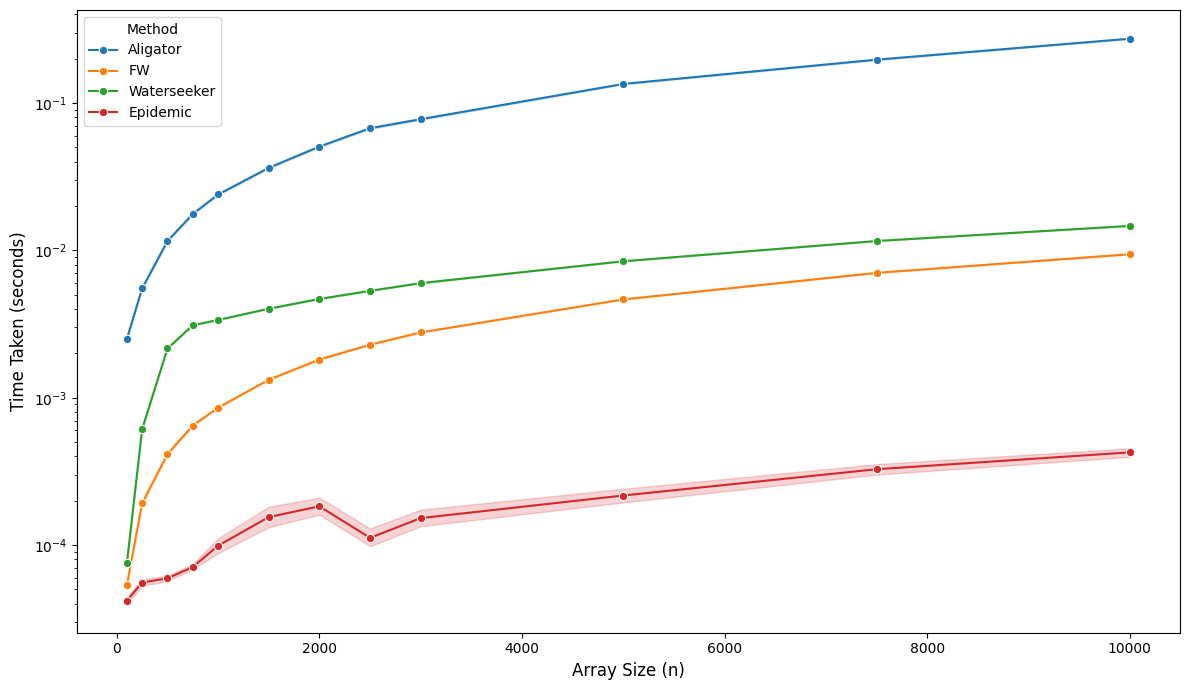

In [23]:
print(timedf.shape)

plt.figure(figsize=(12, 7))
plot = sns.lineplot(
    data=timedf,
    x='n',
    y='time',
    hue='method',
    marker='o',
    errorbar=('ci', 95) # 'ci' shows the 95% confidence interval
)

# plot.set_xscale('log')  # plot in log scale
plot.set_yscale('log')

# plot.set_title('Method Performance vs. Array Size (n)', fontsize=16, weight='bold')
plot.set_xlabel('Array Size (n)', fontsize=12)
plot.set_ylabel('Time Taken (seconds)', fontsize=12)
plt.legend(title='Method', fontsize=10)
plt.tight_layout() # Adjust layout to make sure everything fits

# Ablation Study

In [29]:
# run the Section 1. Some Utility Functions first

fname = "data_google-gemma-3-270m_n501_gumbel.json"
# fname = "data_facebook-opt-125m_n200_gumbel.json"
data = read_json(os.path.join(root_output_path, fname))

true_intervals =  [(start, end) for (start, end, interval_type) in data['configuration']['intervals'] if interval_type != 'unwatermarked']
vocab_size = data['configuration']['vocab_size']

data['configuration']

{'model_name': 'google/gemma-3-270m',
 'intervals': [[0, 100, 'unwatermarked'],
  [100, 200, 'gumbel'],
  [200, 501, 'unwatermarked']],
 'prompt_tokens': 50,
 'out_tokens': 501,
 'vocab_size': 262144,
 'initial_seed': 1234,
 'max_token_input_length': 256}

In [37]:
# run for different block_sizes, and measure the IOU metrics
from itertools import product
from detections import EpidemicDetectorV3
from watermarking_func import null_distn_gumbel


block_sizes = [5, 10, 25, 50, 75, 125, 175, 250]

rows = []
for i, block_size in tqdm(list(product(range(len(data['data'])), block_sizes))):
    pivots = np.array(data['data'][i]['pivots'])
    pivots[np.isinf(pivots)] = pivots[~np.isinf(pivots)].max() # replace by maximum for infinite values

    # perform detection
    d = EpidemicDetectorV3(vocab_size, rho = 0.25)
    est_intervals, time_taken = d.detect(pivots, null_distn_gumbel, block_size=block_size)
    
    rows.append({
        "sample_index": i,
        "block_size": block_size,
        "iou": get_iou(est_intervals, true_intervals),
        "rand_index": get_rand_index(est_intervals, true_intervals, pivots.shape[0])
    })

# convert to dataframe
blocks_df = pd.DataFrame(rows)
blocks_df.shape

  0%|          | 0/1600 [00:00<?, ?it/s]

(1600, 4)

/var/folders/v9/p596rfjn6f5cxry5bh_b_0cw0000gn/T/ipykernel_2020/3206806878.py:15: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.boxplot(data=long_df, x="block_size", y="Score", hue="Metric", palette=palette, width=0.6, fliersize=2)


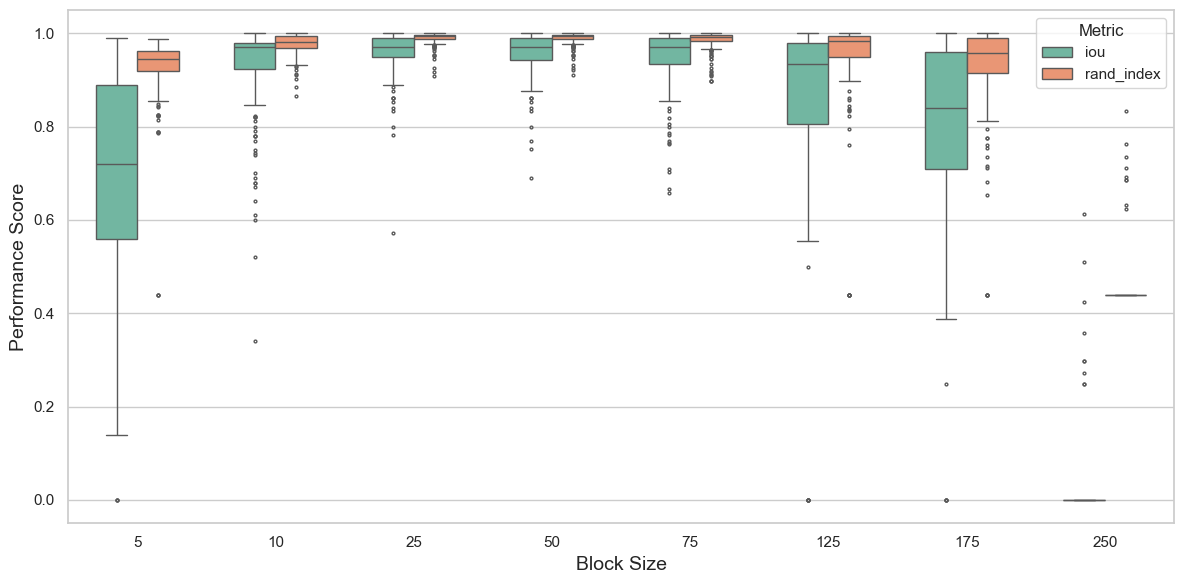

In [38]:
# make a plot for the ablation study

long_df = blocks_df.melt(
    id_vars=["sample_index", "block_size"],
    value_vars=["iou", "rand_index"],
    var_name="Metric",
    value_name="Score"
)

# set style
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2")  # custom color palette (colorblind friendly)

plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=long_df, x="block_size", y="Score", hue="Metric", palette=palette, width=0.6, fliersize=2)

# ax.set_title("Ablation Study: Effect of Block Size on Detection Performance", fontsize=18, pad=20)
ax.set_xlabel("Block Size", fontsize=14)
ax.set_ylabel("Performance Score", fontsize=14)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # rotate x labels if needed
# handles, labels = ax.get_legend_handles_labels() # improve legend
# ax.legend(handles[:2], labels[:2], title="Metric", loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

In [47]:
# same ablation study but for different values of rho
from itertools import product
from detections import EpidemicDetectorV3
from watermarking_func import null_distn_gumbel


rho_vals = np.arange(0.1, 1, step=0.1)

rows = []
for i, rho in tqdm(list(product(range(len(data['data'])), rho_vals))):
    pivots = np.array(data['data'][i]['pivots'])
    pivots[np.isinf(pivots)] = pivots[~np.isinf(pivots)].max() # replace by maximum for infinite values

    # perform detection
    d = EpidemicDetectorV3(vocab_size, rho = round(float(rho), 3))
    est_intervals, time_taken = d.detect(pivots, null_distn_gumbel, block_size=50)  # keep block_size fixed
    
    rows.append({
        "sample_index": i,
        "rho": rho,
        "iou": get_iou(est_intervals, true_intervals),
        "rand_index": get_rand_index(est_intervals, true_intervals, pivots.shape[0])
    })

# convert to dataframe
rho_df = pd.DataFrame(rows)
print(rho_df.shape)

  0%|          | 0/1800 [00:00<?, ?it/s]

(1800, 4)


/var/folders/v9/p596rfjn6f5cxry5bh_b_0cw0000gn/T/ipykernel_2020/2891833957.py:15: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.boxplot(data=long_df, x="rho_label", y="Score", hue="Metric", palette=palette, width=0.6, fliersize=2)


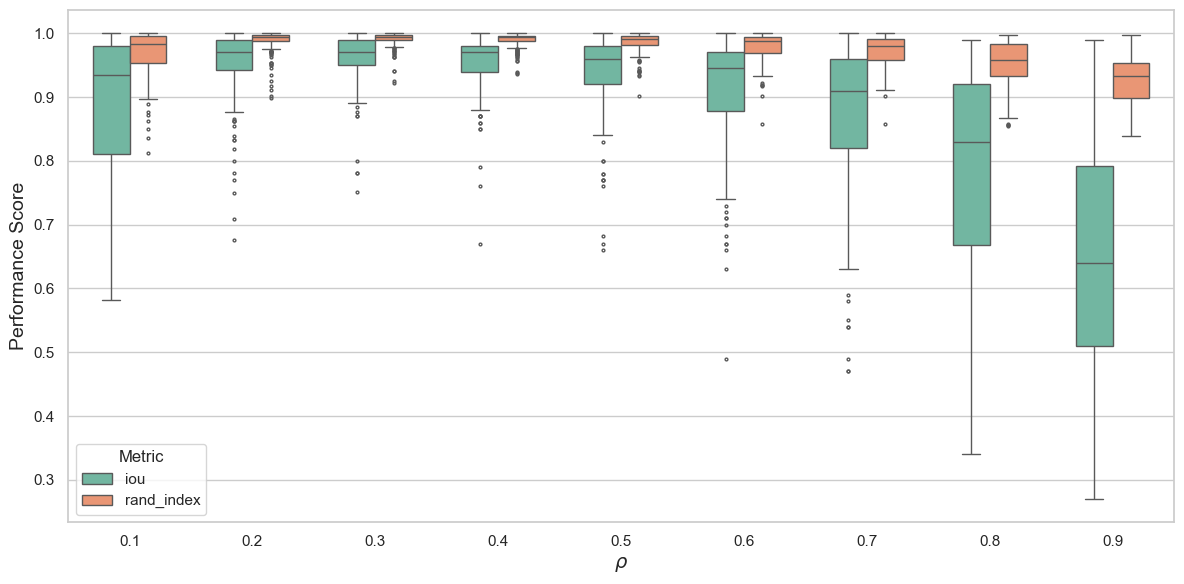

In [48]:
# make the plot
rho_df["rho_label"] = rho_df["rho"].map(lambda x: f"{x:.1f}")
long_df = rho_df.melt(
    id_vars=["sample_index", "rho_label"],
    value_vars=["iou", "rand_index"],
    var_name="Metric",
    value_name="Score"
)

# set style
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2")  # custom color palette (colorblind friendly)

plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=long_df, x="rho_label", y="Score", hue="Metric", palette=palette, width=0.6, fliersize=2)

# ax.set_title("Ablation Study: Effect of Block Size on Detection Performance", fontsize=18, pad=20)
ax.set_xlabel(r"$\rho$", fontsize=14)
ax.set_ylabel("Performance Score", fontsize=14)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # rotate x labels if needed
# handles, labels = ax.get_legend_handles_labels() # improve legend
# ax.legend(handles[:2], labels[:2], title="Metric", loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)

plt.tight_layout()
plt.show()